In [43]:
# I will run 4 simulators on random circuits and log the time and memory

In [1]:
import time
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import quimb as qu
import matplotlib.pyplot as plt
import quimb.tensor as qut
from qtn_sim import *
from rdbmsSimulator.sqlite_mps import *

MAXIMUM_BOND_DIMENSION = 5


c:\Users\k21pa\quantum\qs\Lib\site-packages\cotengra\hyperoptimizers\hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
c:\Users\k21pa\quantum\qs\Lib\site-packages\cotengra\hyperoptimizers\hyper.py:39: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
c:\Users\k21pa\quantum\qs\Lib\site-packages\cotengra\hyperoptimizers\hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


In [ ]:
def myCircuitToQiskit(circuit : QCircuit, n):
    num_qubits = n
    qiskit_circuit = QuantumCircuit(num_qubits)

    for gate, indices in circuit.gateList:
        name = gate.id
        qubits = indices
        params = gate.params
        
        if name == 'H':
            qiskit_circuit.h(qubits[0])
        elif name == 'X':
            qiskit_circuit.x(qubits[0])
        elif name == 'Y':
            qiskit_circuit.y(qubits[0])
        elif name == 'Z':
            qiskit_circuit.z(qubits[0])
        elif name == 'S':
            qiskit_circuit.s(qubits[0])
        elif name == 'T':
            qiskit_circuit.t(qubits[0])
        elif name == 'CNOT':
            qiskit_circuit.cx(qubits[0], qubits[1])
        elif name == 'SWAP':
            qiskit_circuit.swap(qubits[0], qubits[1])
        elif name == 'CP':
            qiskit_circuit.cp(params[0], qubits[0], qubits[1])
        elif name == 'CZ':
            qiskit_circuit.cz(qubits[0], qubits[1])
        elif name == 'CRY':
            qiskit_circuit.cry(params[0], qubits[0], qubits[1])
        elif name == 'TOFFOLI' or name == 'CCX':
            qiskit_circuit.ccx(qubits[0], qubits[1], qubits[2])
        else:
            raise ValueError(f"Unsupported gate: {name}")

    simulator = AerSimulator(method='matrix_product_state', matrix_product_state_max_bond_dimension=MAXIMUM_BOND_DIMENSION)
    return simulator.run(transpile(qiskit_circuit))

def myCircuitToQuimb(circuit : QCircuit, num_qubits):
    c = qut.CircuitMPS(N=num_qubits, max_bond=MAXIMUM_BOND_DIMENSION)
    for gate, indices in circuit.gateList:
        c.apply_gate(gate_id=gate.id, params=gate.params,qubits=indices)
    return c

def myCircuitToSqlLiteJson(n, circuit: QCircuit):
    gateList = []
    for (gate, indices) in circuit.gateList:
        gateList.append({
            "qubits":indices,
            "gate":gate.id,
            "parameters":gate.params
        })
    json = {
        "number_of_qubits": n,
        "gates": gateList
    }
    return json


In [44]:
gatesAllowed = {**singleQGateMap, **twoQGateMap}
gatesAllowed.pop('CP', None)
gatesAllowed.pop('RY', None)

numberOfCircuits = 100
numberOfQubits = 50
maxCircuitDepth = 50
p = 0.0
circuits = createCircuits(numberOfCircuits=numberOfCircuits, 
                          numberOfQubits=numberOfQubits, 
                          maxCircuitDepth=maxCircuitDepth, 
                          gatesUsed=gatesAllowed, 
                          probablityOfAdjacent=p, 
                          filePath="circuits.json")

In [45]:
circuitsRead = readCircuits("circuits.json")

In [46]:
def getTimeMemory(func, args):
    start = time.perf_counter_ns()
    tracemalloc.start()

    func(*args)

    mem = tracemalloc.get_traced_memory()

    tracemalloc.stop()

    end = time.perf_counter_ns()
    timeIt = end - start

    return timeIt, mem[1]


In [47]:
import pandas as pd


# Initialize arrays to store time and memory usage
time_aer = []
mem_aer = []
time_quimb = []
mem_quimb = []
time_qtn_sim = []
mem_qtn_sim = []
time_rdbms = []
mem_rdbms = []

# Iterate over the circuits and run the simulators
for circuit in circuitsRead:
    # Run AerSimulator
    time_it, mem = getTimeMemory(myCircuitToQiskit, [circuit, numberOfQubits])
    time_aer.append(time_it)
    mem_aer.append(mem)
    
    # Run quimb
    time_it, mem = getTimeMemory(myCircuitToQuimb, [circuit,numberOfQubits])
    time_quimb.append(time_it)
    mem_quimb.append(mem)
    
    # Run QuantumMPS
    
    time_it, mem = getTimeMemory(lambda c, n : QuantumMPS(n).applyCircuit(circuitFromJSONDict(circuit.toJSONDict())), [circuit, numberOfQubits])
    time_qtn_sim.append(time_it)
    mem_qtn_sim.append(mem)

    # Run on SQLLitse simulator
    rdbmsJson = myCircuitToSqlLiteJson(numberOfQubits, circuit)
    time_it, mem = getTimeMemory(SQLITE_MPS.run_circuit_json, [rdbmsJson])
    time_rdbms.append(time_it)
    mem_rdbms.append(mem)

# Initialize a dictionary to store the results
results = {
    'time_aer': time_aer,
    'mem_aer': mem_aer,
    'time_quimb': time_quimb,
    'mem_quimb': mem_quimb,
    'time_qtn_sim': time_qtn_sim,
    'mem_qtn_sim': mem_qtn_sim,
    'time_rdbms': time_rdbms,
    'mem_rdbms': mem_rdbms
}

# Convert the dictionary to a DataFrame
df_results = pd.DataFrame(results)
df_results.to_csv("simulationData.csv")

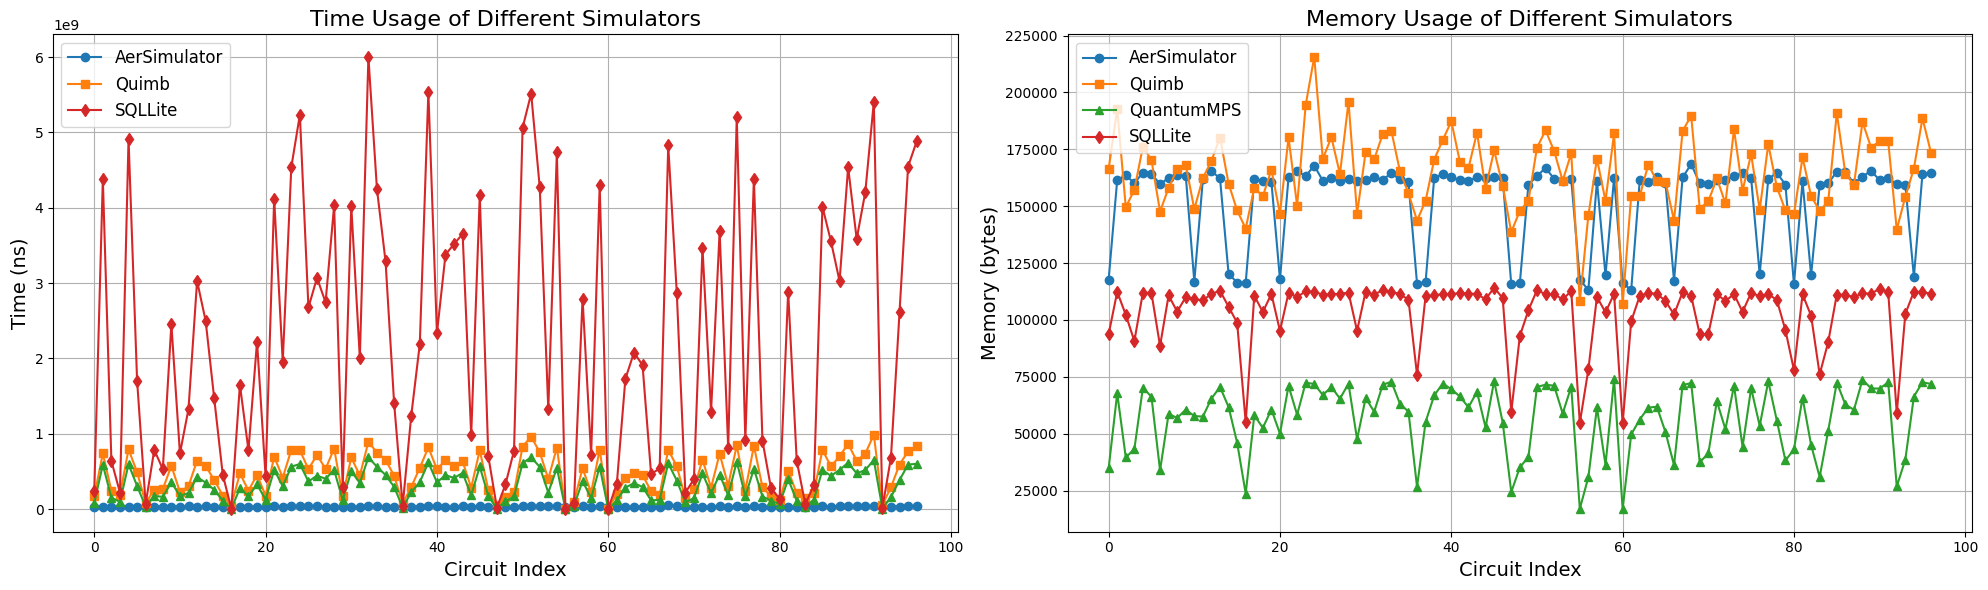

In [ ]:
# Plot time and memory usage side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Define a color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot time usage
axs[0].plot(time_aer[3:], label='AerSimulator', color=colors[0], marker='o')
axs[0].plot(time_quimb[3:], label='Quimb', color=colors[1], marker='s')
axs[0].plot(time_qtn_sim[3:], label='QuantumMPS', color=colors[2], marker='^')
axs[0].plot(time_rdbms[3:], label='SQLLite', color=colors[3], marker='d')
axs[0].set_xlabel('Circuit Index', fontsize=14)
axs[0].set_ylabel('Time (ns)', fontsize=14)
axs[0].set_title('Time Usage of Different Simulators', fontsize=16)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# Plot memory usage
axs[1].plot(mem_aer[3:], label='AerSimulator', color=colors[0], marker='o')
axs[1].plot(mem_quimb[3:], label='Quimb', color=colors[1], marker='s')
axs[1].plot(mem_qtn_sim[3:], label='QuantumMPS', color=colors[2], marker='^')
axs[1].plot(mem_rdbms[3:], label='SQLLite', color=colors[3], marker='d')
axs[1].set_xlabel('Circuit Index', fontsize=14)
axs[1].set_ylabel('Memory (bytes)', fontsize=14)
axs[1].set_title('Memory Usage of Different Simulators', fontsize=16)
axs[1].legend(fontsize=12)
axs[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()